## Download the dataset

In [1]:
!pip install gdown

  Using cached gdown-4.2.0-py3-none-any.whl
  Using cached beautifulsoup4-4.10.0-py3-none-any.whl (97 kB)
  Using cached soupsieve-2.3.1-py3-none-any.whl (37 kB)


In [2]:
!gdown https://drive.google.com/uc?id=1_T3Wy1j0Ocn80oHM8Ilgz7mn-SI_1SxT

Downloading...
From: https://drive.google.com/uc?id=1_T3Wy1j0Ocn80oHM8Ilgz7mn-SI_1SxT
To: /home/studio-lab-user/train_small_images.tar.gz
100%|█████████████████████████████████████████| 649M/649M [00:05<00:00, 112MB/s]


In [3]:
!tar -xvzf train_small_images.tar.gz

content/train/
content/train/.ipynb_checkpoints/
content/train/masks/
content/train/masks/house_seg_hurricane-michael_00000473_pre_disaster.png
content/train/masks/house_seg_socal-fire_00000579_pre_disaster.png
content/train/masks/house_seg_hurricane-harvey_00000178_post_disaster.png
content/train/masks/socal-fire_00000677_pre_disaster.png
content/train/masks/house_seg_socal-fire_00000220_pre_disaster.png
content/train/masks/socal-fire_00000473_post_disaster.png
content/train/masks/mexico-earthquake_00000041_post_disaster.png
content/train/masks/hurricane-matthew_00000000_post_disaster.png
content/train/masks/socal-fire_00001346_post_disaster.png
content/train/masks/house_seg_hurricane-florence_00000049_post_disaster.png
content/train/masks/hurricane-florence_00000136_pre_disaster.png
content/train/masks/midwest-flooding_00000408_pre_disaster.png
content/train/masks/house_seg_hurricane-harvey_00000116_pre_disaster.png
content/train/masks/house_seg_hurricane-harvey_00000212_post_disaste

In [5]:
!rm train_small_images.tar.gz

## Load and visualise the data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from PIL import Image

In [2]:
IMAGES_BASE_PATH = 'train/images/'
MASKS_BASE_PATH = 'train/masks/'

In [3]:
image_names = os.listdir(IMAGES_BASE_PATH)
print(len(image_names))

5599


In [4]:
# Remove corrupt images
for filename in image_names:
    statfile = os.stat(f'{IMAGES_BASE_PATH}{filename}')
    filesize = statfile.st_size
    if filesize == 0:
        print(filename)
        os.remove(f'{IMAGES_BASE_PATH}{filename}')
        os.remove(f'{MASKS_BASE_PATH}{filename}')
        os.remove(f'{MASKS_BASE_PATH}house_seg_{filename}')

In [5]:
pre_disaster_images = [image_name for image_name in image_names if image_name.endswith('_pre_disaster.png')]
post_disaster_images = [image_name for image_name in image_names if image_name.endswith('_post_disaster.png')]
print(len(pre_disaster_images))
print(len(post_disaster_images))

2799
2799


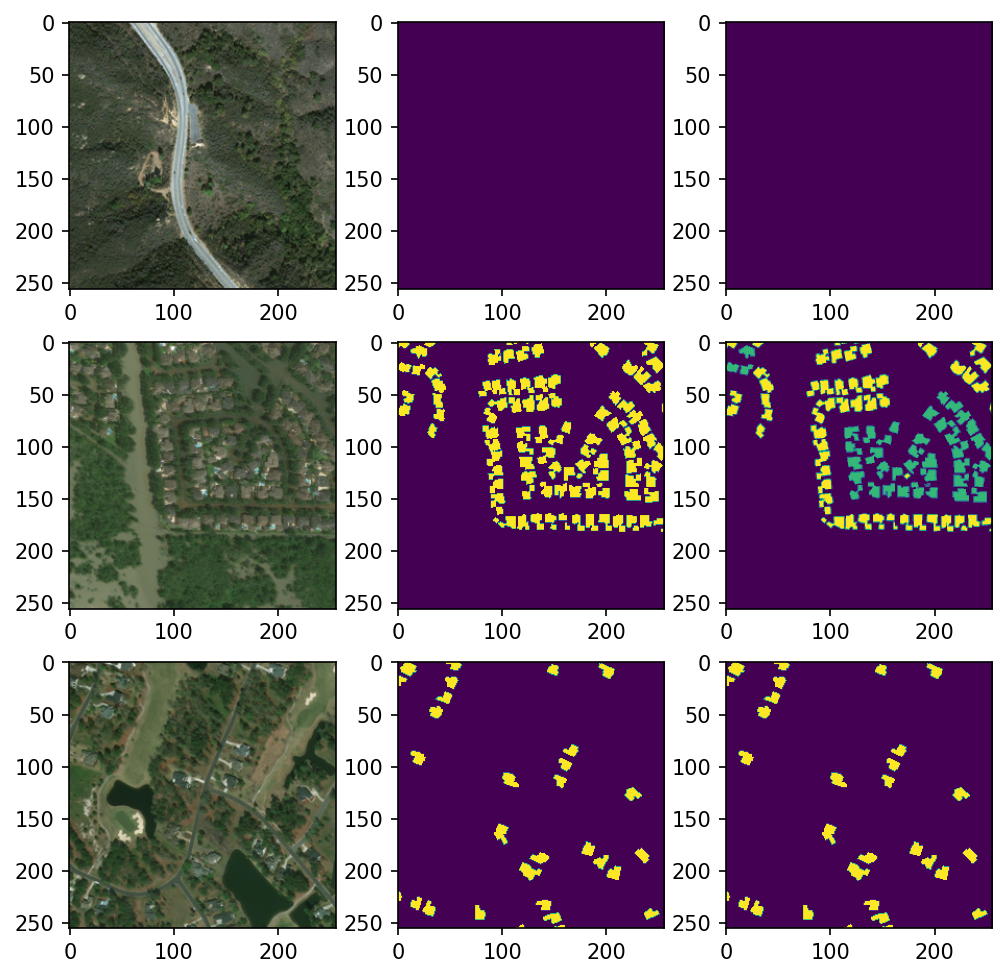

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(8,8))
fig.set_dpi(150)
offset = 140
for idx in range(3):
    original = pltimg.imread(f'{IMAGES_BASE_PATH}{image_names[idx + offset]}')
    mask_damage = pltimg.imread(f'{MASKS_BASE_PATH}{image_names[idx + offset]}')
    mask_seg = pltimg.imread(f'{MASKS_BASE_PATH}house_seg_{image_names[idx + offset]}')
    ax[idx][0].imshow(original)
    ax[idx][1].imshow(mask_seg)
    ax[idx][2].imshow(mask_damage)

## Load pre-disaster dataset

In [7]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

In [8]:
TARGET_SHAPE_IMAGE = [256, 256, 3]
TARGET_SHAPE_MASK = [256, 256, 1]

In [9]:
m = len(pre_disaster_images)
i_h, i_w, i_c = TARGET_SHAPE_IMAGE
m_h, m_w, m_c = TARGET_SHAPE_MASK

In [93]:
class_weights = np.array([1.05060410e+00, 2.39747709e+01, 4.56155391e+02, 3.53742567e+02, 8.07774831e+02, 5.02425577e+03])
class_weights = np.log(class_weights)
print(class_weights)

[0.04936533 3.17700206 6.12283352 5.86856944 6.69428335 8.52203262]


In [101]:
class_weights = [0, 0]

In [102]:
for image in tqdm(pre_disaster_images):
    img = Image.open(f'{MASKS_BASE_PATH}house_seg_{image}')
    img = np.array(img)
    ctr = np.unique(img, return_counts=True)
    for i in range(len(ctr[0])):
        class_weights[ctr[0][i]] += ctr[1][i]

100%|██████████| 2799/2799 [00:03<00:00, 781.98it/s]


In [103]:
class_weights = np.array(class_weights)
class_weights = np.sum(class_weights) / (2 * class_weights)
# class_weights = np.log(class_weights)
print(class_weights)

[0.5268499  9.81102087]


In [17]:
def get_image_with_mask(filename):
    img = tf.io.read_file(filename[0])
    img = tf.image.decode_png(img)
    img = tf.image.resize(img, (i_w, i_h))

    mask = tf.io.read_file(filename[1])
    mask = tf.image.decode_png(mask)
    mask = tf.image.resize(mask, (m_w, m_h))

    return img, mask

def scale_img(image, mask):
    return image / 255., mask

def add_sample_weights(image, mask):
    global class_weights
    cw = tf.constant(class_weights)
    # class_weights = class_weights/tf.reduce_sum(class_weights)

    sample_weights = tf.gather(cw, indices=tf.cast(mask, tf.int32))

    return image, mask, sample_weights

In [110]:
image_names = [f'{IMAGES_BASE_PATH}{image}' for image in pre_disaster_images]
image_names = np.reshape(image_names, (len(image_names), 1))

mask_names = [f'{MASKS_BASE_PATH}house_seg_{mask}' for mask in pre_disaster_images]
mask_names = np.reshape(mask_names, (len(mask_names), 1))

dataset = tf.concat([image_names, mask_names], axis=1)
dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(10)

dataset = dataset.map(get_image_with_mask).map(scale_img).map(add_sample_weights)

for image, mask, weight in dataset.take(1):
    print("Image: ", image)
    print("Mask: ", mask)
    print("Weights: ", np.unique(weight.numpy()))

Image:  tf.Tensor(
[[[0.15294118 0.25490198 0.12941177]
  [0.12941177 0.24313726 0.11764706]
  [0.12156863 0.23921569 0.11372549]
  ...
  [0.3254902  0.3647059  0.23137255]
  [0.34901962 0.39607844 0.2627451 ]
  [0.32156864 0.38039216 0.27450982]]

 [[0.23921569 0.3019608  0.16862746]
  [0.19607843 0.27450982 0.14509805]
  [0.19215687 0.28235295 0.14509805]
  ...
  [0.2509804  0.29411766 0.18431373]
  [0.3529412  0.39215687 0.25490198]
  [0.34117648 0.39215687 0.26666668]]

 [[0.28627452 0.32156864 0.19215687]
  [0.2509804  0.2901961  0.16862746]
  [0.2509804  0.29411766 0.16862746]
  ...
  [0.19607843 0.23137255 0.14117648]
  [0.3019608  0.34509805 0.21176471]
  [0.35686275 0.40392157 0.25490198]]

 ...

 [[0.35686275 0.36862746 0.23529412]
  [0.22745098 0.28627452 0.16862746]
  [0.14901961 0.22745098 0.1254902 ]
  ...
  [0.14509805 0.19215687 0.1254902 ]
  [0.16470589 0.19607843 0.1254902 ]
  [0.18431373 0.21176471 0.13333334]]

 [[0.38039216 0.3764706  0.24313726]
  [0.25490198 0.30

In [111]:
m = len(dataset)
train_size = int(m * 0.8)

train_set, val_set = dataset.take(train_size).batch(64), dataset.skip(train_size).batch(64)
print(len(train_set))
print(len(val_set))

35
9


## Define U-Net Model

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.losses import binary_crossentropy

In [21]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    
    conv = BatchNormalization()(conv, training=False)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [22]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(n_filters, (3, 3), strides=(2,2), padding='same')(prev_layer_input)
    
    merge = concatenate([up, skip_layer_input], axis=3)
    
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    return conv

In [23]:
def UNet(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    inputs = Input(input_size)
    
    cb1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cb2 = EncoderMiniBlock(cb1[0], 2 * n_filters, dropout_prob=0, max_pooling=True)
    cb3 = EncoderMiniBlock(cb2[0], 4 * n_filters, dropout_prob=0, max_pooling=True)
    cb4 = EncoderMiniBlock(cb3[0], 8 * n_filters, dropout_prob=0.3, max_pooling=True)
    cb5 = EncoderMiniBlock(cb4[0], 16 * n_filters, dropout_prob=0.3, max_pooling=False) 
    
    ub6 = DecoderMiniBlock(cb5[0], cb4[1], 8 * n_filters)
    ub7 = DecoderMiniBlock(ub6, cb3[1], 4 * n_filters)
    ub8 = DecoderMiniBlock(ub7, cb2[1], 2 * n_filters)
    ub9 = DecoderMiniBlock(ub8, cb1[1], n_filters)
    
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(ub9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

In [116]:
unet = UNet(input_size=(256, 256, 3), n_filters=16, n_classes=2)

In [117]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_40[0][0]']              
                                )                                                           

In [118]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [134]:
results = unet.fit(x=train_set, batch_size=64, epochs=5, validation_data=val_set)

Epoch 1/5
35/35 [==============================] - 32s 923ms/step - loss: 0.1891 - accuracy: 0.8600 - val_loss: 0.1985 - val_accuracy: 0.8330
Epoch 2/5
35/35 [==============================] - 32s 930ms/step - loss: 0.2008 - accuracy: 0.8574 - val_loss: 0.2267 - val_accuracy: 0.8012
Epoch 3/5
35/35 [==============================] - 33s 934ms/step - loss: 0.1900 - accuracy: 0.8606 - val_loss: 0.2156 - val_accuracy: 0.8033
Epoch 4/5
35/35 [==============================] - 33s 939ms/step - loss: 0.1881 - accuracy: 0.8600 - val_loss: 0.1873 - val_accuracy: 0.8622
Epoch 5/5
35/35 [==============================] - 33s 941ms/step - loss: 0.1760 - accuracy: 0.8668 - val_loss: 0.1863 - val_accuracy: 0.8499


In [140]:
unet.save('pre_disaster_segmentation-correct-weights-22-epochs.h5')

## Evaluate the results

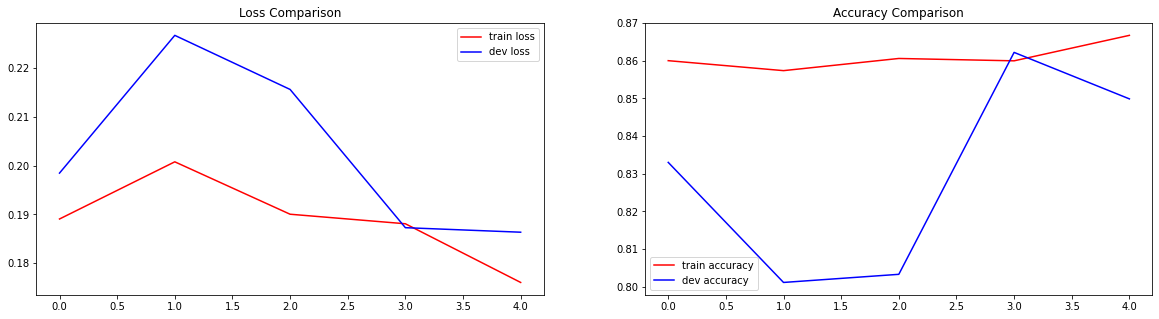

In [135]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [136]:
unet.evaluate(val_set)

9/9 [==============================] - 6s 306ms/step - loss: 0.1876 - accuracy: 0.8485


[0.18759898841381073, 0.8485262989997864]

In [30]:
from PIL import Image
import matplotlib.image as im

def VisualizeResults(index):
    print(image_names[index][0])

    img = Image.open(image_names[index][0]).convert('RGB')
    img = img.resize((i_h, i_w))
    img = np.array(img)
    img = img / 255.
    img = img[np.newaxis, ...]

    actual_mask = im.imread(mask_names[index][0])
    
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = pred_mask.numpy()
    pred_mask = pred_mask.reshape((i_h, i_w))
    
    print(np.unique(actual_mask, return_counts=True))
    print(np.unique(pred_mask, return_counts=True))

    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(img[0])
    arr[0].set_title('Processed Image')
    arr[1].imshow(actual_mask)
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask)
    arr[2].set_title('Predicted Masked Image ')

train/images/hurricane-florence_00000091_pre_disaster.png
(array([0.        , 0.00392157], dtype=float32), array([58111,  7425]))
(array([0, 1]), array([45585, 19951]))
train/images/socal-fire_00001312_pre_disaster.png
(array([0.        , 0.00392157], dtype=float32), array([65358,   178]))
(array([0, 1]), array([64628,   908]))
train/images/hurricane-harvey_00000255_pre_disaster.png
(array([0.        , 0.00392157], dtype=float32), array([64652,   884]))
(array([0, 1]), array([62374,  3162]))


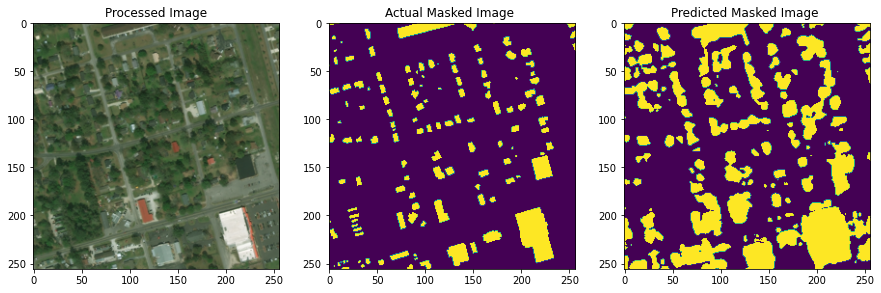

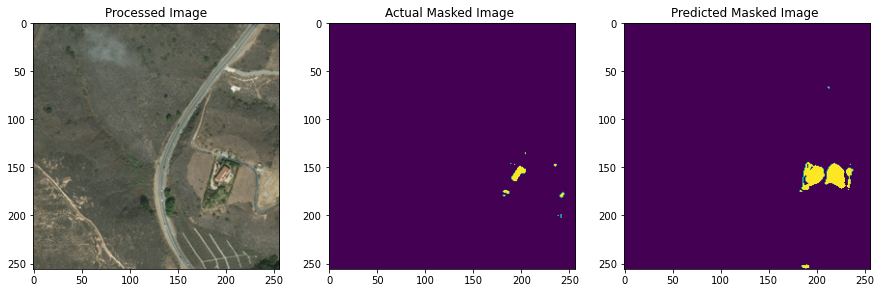

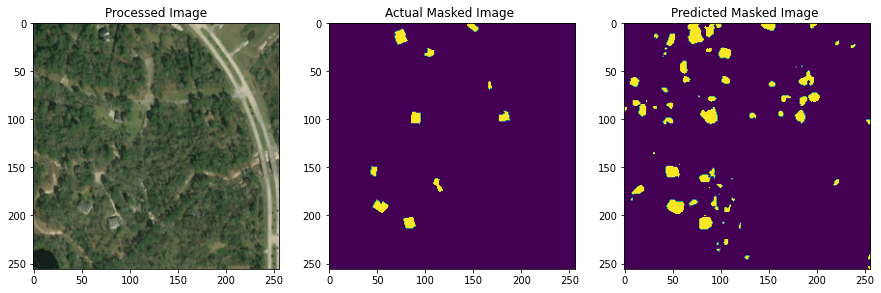

In [143]:
offset = 1131
for i in range(0, 3):
    VisualizeResults(offset + i)

## Load post-disaster dataset

In [10]:
TARGET_SHAPE_IMAGE = [256, 256, 3]
TARGET_SHAPE_MASK = [256, 256, 1]

In [13]:
m = len(post_disaster_images)
i_h, i_w, i_c = TARGET_SHAPE_IMAGE
m_h, m_w, m_c = TARGET_SHAPE_MASK

In [14]:
class_weights = [0, 0]

In [15]:
for image in tqdm(post_disaster_images):
    img = Image.open(f'{MASKS_BASE_PATH}house_seg_{image}')
    img = np.array(img)
    ctr = np.unique(img, return_counts=True)
    for i in range(len(ctr[0])):
        class_weights[ctr[0][i]] += ctr[1][i]

100%|██████████| 2799/2799 [00:04<00:00, 591.64it/s]


In [16]:
class_weights = np.array(class_weights)
class_weights = np.sum(class_weights) / (2 * class_weights)
# class_weights = np.log(class_weights)
print(class_weights)

[0.52666428 9.87583945]


In [18]:
image_names = [f'{IMAGES_BASE_PATH}{image}' for image in post_disaster_images]
image_names = np.reshape(image_names, (len(image_names), 1))

mask_names = [f'{MASKS_BASE_PATH}house_seg_{mask}' for mask in post_disaster_images]
mask_names = np.reshape(mask_names, (len(mask_names), 1))

dataset = tf.concat([image_names, mask_names], axis=1)
dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(10)

dataset = dataset.map(get_image_with_mask).map(scale_img).map(add_sample_weights)

for image, mask, weight in dataset.take(1):
    print("Image: ", image)
    print("Mask: ", mask)
    print("Weights: ", np.unique(weight.numpy()))

Image:  tf.Tensor(
[[[0.25490198 0.28235295 0.2509804 ]
  [0.24313726 0.27450982 0.24313726]
  [0.24313726 0.27450982 0.24313726]
  ...
  [0.2627451  0.28235295 0.25490198]
  [0.2627451  0.2784314  0.24705882]
  [0.27058825 0.28627452 0.24313726]]

 [[0.23921569 0.27058825 0.23137255]
  [0.24705882 0.27450982 0.23529412]
  [0.23921569 0.26666668 0.23137255]
  ...
  [0.27450982 0.29411766 0.25490198]
  [0.27058825 0.28627452 0.24705882]
  [0.29803923 0.3137255  0.26666668]]

 [[0.24313726 0.27058825 0.23137255]
  [0.25882354 0.28235295 0.24313726]
  [0.25490198 0.27450982 0.23529412]
  ...
  [0.29803923 0.30588236 0.25490198]
  [0.29803923 0.30588236 0.25882354]
  [0.32156864 0.32941177 0.2784314 ]]

 ...

 [[0.7372549  0.7254902  0.6313726 ]
  [0.57254905 0.5686275  0.47058824]
  [0.60784316 0.6039216  0.49019608]
  ...
  [0.37254903 0.3882353  0.3137255 ]
  [0.3647059  0.40784314 0.3254902 ]
  [0.34509805 0.41568628 0.30980393]]

 [[0.80784315 0.7764706  0.69411767]
  [0.79607844 0.76

In [19]:
m = len(dataset)
train_size = int(m * 0.8)

train_set, val_set = dataset.take(train_size).batch(64), dataset.skip(train_size).batch(64)
print(len(train_set))
print(len(val_set))

35
9


## Define Post-Disaster Model

In [24]:
unet = UNet(input_size=(256, 256, 3), n_filters=16, n_classes=2)

In [25]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [26]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [45]:
results = unet.fit(x=train_set, batch_size=64, epochs=10, validation_data=val_set)

Epoch 1/10
35/35 [==============================] - 31s 887ms/step - loss: 0.2525 - accuracy: 0.8226 - val_loss: 0.2476 - val_accuracy: 0.8384
Epoch 2/10
35/35 [==============================] - 31s 895ms/step - loss: 0.2507 - accuracy: 0.8223 - val_loss: 0.2452 - val_accuracy: 0.8383
Epoch 3/10
35/35 [==============================] - 31s 901ms/step - loss: 0.2519 - accuracy: 0.8252 - val_loss: 0.2520 - val_accuracy: 0.8580
Epoch 4/10
35/35 [==============================] - 32s 907ms/step - loss: 0.2400 - accuracy: 0.8295 - val_loss: 0.2352 - val_accuracy: 0.8561
Epoch 5/10
35/35 [==============================] - 32s 916ms/step - loss: 0.2456 - accuracy: 0.8307 - val_loss: 0.2518 - val_accuracy: 0.8521
Epoch 6/10
35/35 [==============================] - 32s 927ms/step - loss: 0.2390 - accuracy: 0.8316 - val_loss: 0.2435 - val_accuracy: 0.8570
Epoch 7/10
35/35 [==============================] - 33s 935ms/step - loss: 0.2340 - accuracy: 0.8332 - val_loss: 0.2595 - val_accuracy: 0.8589

In [51]:
unet.save('post_disaster_segmentation-correct-weights-10-epochs.h5')

## Evaluate post-disaster results

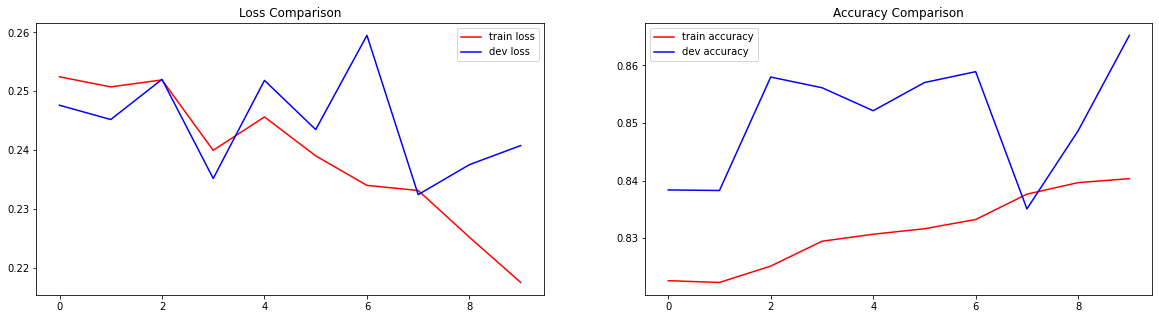

In [46]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [47]:
unet.evaluate(val_set)

9/9 [==============================] - 6s 313ms/step - loss: 0.2388 - accuracy: 0.8675


[0.23881931602954865, 0.8674882650375366]

train/images/hurricane-matthew_00000013_post_disaster.png
(array([0.], dtype=float32), array([65536]))
(array([0, 1]), array([65152,   384]))
train/images/palu-tsunami_00000161_post_disaster.png
(array([0.        , 0.00392157], dtype=float32), array([54266, 11270]))
(array([0, 1]), array([28937, 36599]))
train/images/socal-fire_00000569_post_disaster.png
(array([0.], dtype=float32), array([65536]))
(array([0]), array([65536]))


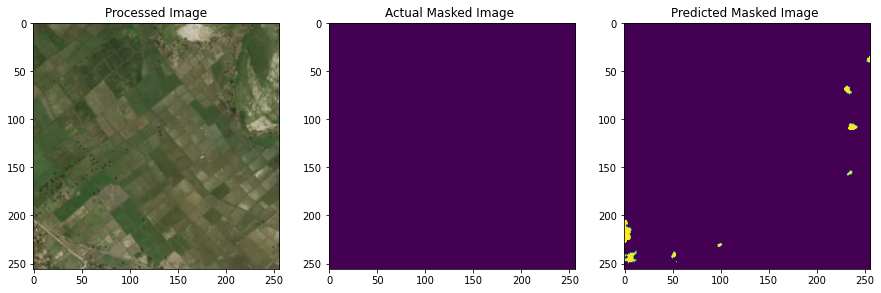

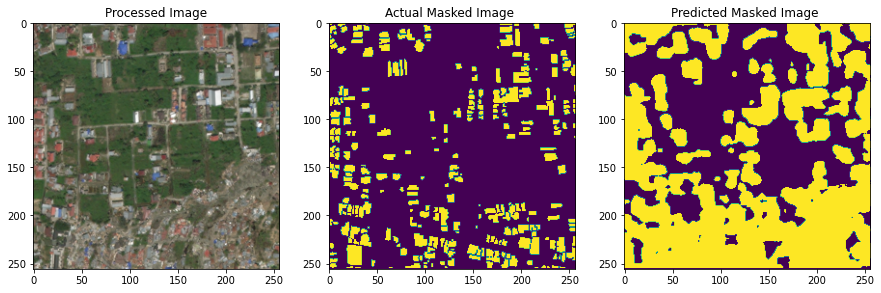

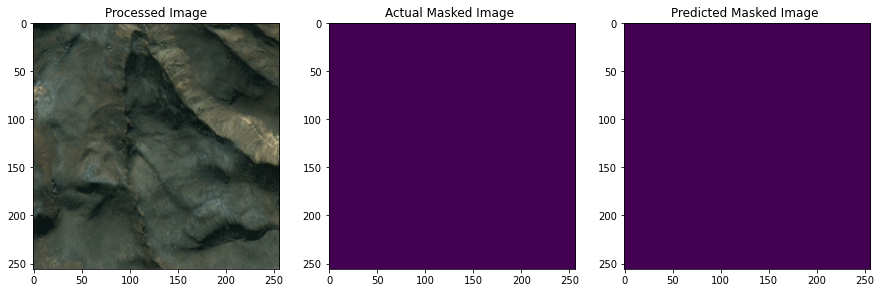

In [55]:
offset = 1049
for i in range(0, 3):
    VisualizeResults(offset + i)